In [78]:
import gym
import numpy as np
from math import exp, log
from random import choice, uniform, sample
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from kaggle_environments import evaluate, make

In [79]:
class ConnectX(gym.Env):
    
    def __init__(self, switch_prob=0.5):
        self.env = make('connectx', debug=True)
        self.pair = [None, 'random']
        self.trainer = self.env.train(self.pair)
        self.switch_prob = switch_prob
        config = self.env.configuration
        self.observation_space = gym.spaces.Box(low=0, high=2, shape=(config.rows,config.columns,1), dtype=np.int)

    def switch_side(self):
        self.pair = self.pair[::-1]
        self.trainer = self.env.train(self.pair)
    
    def switch_trainer(self):
        current_trainer_random = 'random' in self.pair 
        if current_trainer_random:
            self.pair = [None, 'negamax']
        else:
            self.pair = [None, 'random']
        self.trainer = self.env.train(self.pair)
    
    def step(self, action):
        return self.trainer.step(action)
    
    def reset(self):
        if uniform(0, 1) < self.switch_prob: # switch side
            self.switch_side()        
        return self.trainer.reset()

In [80]:
class DQNAgent:

    def __init__(self, state_size, action_size, episodes):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=500)
        self.gamma = 0.9
        self.epsilon = 0.10
        self.epsilon_min = 0.01
        self.epsilon_decay = exp((log(self.epsilon_min) - log(self.epsilon)) / (0.8 * episodes)) # reaches epsilon_min after 80% of iterations
        self.model = self._build_model()
    
    def _build_model(self):
        model = Sequential()
        model.add(Dense(20, input_dim=self.state_size, activation='relu'))
        model.add(Dense(50, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse',
                      optimizer=Adam(learning_rate = 0.0001))
        return model
    
    def memorize(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
    
    def act(self, state):
        if np.random.rand() <= self.epsilon: # Exploration
            return choice([c for c in range(self.action_size) if state[:,c] == 0])
        act_values = self.model.predict(state) # Exploitation
        action = np.argmax(act_values[0]) 
        return action
    
    def replay(self, batch_size):
        minibatch = sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = reward + self.gamma * np.amax(self.model.predict(next_state)[0])
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        self.model.load_weights(name)
    
    def save(self, name):
        self.model.save_weights(name)

In [81]:
# initialize gym environment and the agent
env = ConnectX(switch_prob = 0.5)
state_size = env.observation_space.shape[1] * env.observation_space.shape[0]
action_size = env.observation_space.shape[1]
episodes = 10000
agent = DQNAgent(state_size, action_size, episodes)
agent.load("./connectX-weights_deep.h5") # load prelearned weights
batch_size = 40

# Monitoring devices
all_total_rewards = np.empty(episodes)
all_avg_rewards = np.empty(episodes)

# Iterate the game
for e in range(episodes):
    done = False
    state = env.reset()
    total_rewards = 0
    while not done:
        # Decide action
        action = int(agent.act(np.array([state["board"]])))
        next_state, reward, done, _ = env.step(action)
        if not done:
            reward = 0.5
        if done:
            if reward == 1: # Won
                reward = 1
            elif reward == 0: # Lost
                reward = -1
            else: # Draw
                reward = 0
        if state["board"][action] != 0:
            reward = -10
        agent.memorize(np.array([state["board"]]), action, reward, np.array([next_state["board"]]), done)
        state = next_state
        total_rewards += reward
    if len(agent.memory) > batch_size:
        agent.replay(batch_size)
        all_total_rewards[e] = total_rewards
        avg_reward = all_total_rewards[max(0, e - 100):e].mean()
        all_avg_rewards[e] = avg_reward
        if e % 100 == 0 :
            agent.save("./connectX-weights_deep.h5")
            print("episode: {}/{}, epsilon: {:.2f}, average: {:.2f}".format(e, episodes, agent.epsilon, avg_reward))

<ipython-input-79-8ff63c5a1ecb>:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.observation_space = gym.spaces.Box(low=0, high=2, shape=(config.rows,config.columns,1), dtype=np.int)


Invalid Action: Invalid column: 4
Invalid Action: Invalid column: 6
Invalid Action: Invalid column: 4
Invalid Action: Invalid column: 4
Invalid Action: Invalid column: 6
Invalid Action: Invalid column: 3
Invalid Action: Invalid column: 3
episode: 100/10000, epsilon: 0.10, average: nan
Invalid Action: Invalid column: 1
Invalid Action: Invalid column: 1
Invalid Action: Invalid column: 1
Invalid Action: Invalid column: 4
Invalid Action: Invalid column: 5
Invalid Action: Invalid column: 5
Invalid Action: Invalid column: 6
Invalid Action: Invalid column: 6
episode: 200/10000, epsilon: 0.09, average: 3.29
Invalid Action: Invalid column: 6
Invalid Action: Invalid column: 6
Invalid Action: Invalid column: 6
Invalid Action: Invalid column: 0
Invalid Action: Invalid column: 6
Invalid Action: Invalid column: 0
Invalid Action: Invalid column: 0
Invalid Action: Invalid column: 6
Invalid Action: Invalid column: 2
Invalid Action: Invalid column: 2
Invalid Action: Invalid column: 3
Invalid Action: Inv

Invalid Action: Invalid column: 5
episode: 4500/10000, epsilon: 0.03, average: 4.56
episode: 4600/10000, epsilon: 0.03, average: 4.86
Invalid Action: Invalid column: 1
Invalid Action: Invalid column: 2
episode: 4700/10000, epsilon: 0.03, average: 4.62
Invalid Action: Invalid column: 3
Invalid Action: Invalid column: 5
episode: 4800/10000, epsilon: 0.03, average: 4.87
Invalid Action: Invalid column: 0
Invalid Action: Invalid column: 1
episode: 4900/10000, epsilon: 0.02, average: 4.17
Invalid Action: Invalid column: 3
Invalid Action: Invalid column: 4
episode: 5000/10000, epsilon: 0.02, average: 4.58
episode: 5100/10000, epsilon: 0.02, average: 4.51
Invalid Action: Invalid column: 1
Invalid Action: Invalid column: 0
Invalid Action: Invalid column: 6
episode: 5200/10000, epsilon: 0.02, average: 4.54
Invalid Action: Invalid column: 1
episode: 5300/10000, epsilon: 0.02, average: 5.00
Invalid Action: Invalid column: 4
Invalid Action: Invalid column: 2
episode: 5400/10000, epsilon: 0.02, aver

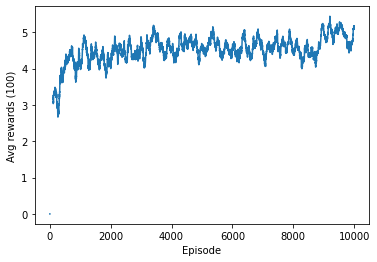

In [82]:
import matplotlib.pyplot as plt
plt.plot(all_avg_rewards)
plt.xlabel('Episode')
plt.ylabel('Avg rewards (100)')
plt.show()

In [84]:
model = Sequential()
model.add(Dense(20, input_dim=state_size, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(action_size, activation='linear'))
model.load_weights('connectX-weights_deep.h5')


layers = []

# Get all layers' weights
for i in range(3):
    weights, biases = model.layers[i].get_weights()
    layers.extend([weights, biases])

layers = list(map(
    lambda x: str(list(np.round(x, 6))).replace('array(', '').replace(')', '').replace(' ', '').replace('\n', '').replace(',dtype=float32',''),
    layers
))
layers = np.reshape(fc_layers, (-1, 2))

# Create the agent
my_agent = '''def my_agent(observation, configuration):
    import numpy as np

'''
# Write hidden layers
for i, (w, b) in enumerate(fc_layers[:-1]):
    my_agent += f'    l{i}_w = np.array({w}, dtype=np.float32)\n'
    my_agent += f'    l{i}_b = np.array({b}, dtype=np.float32)\n'

my_agent += f'    ol_w = np.array({fc_layers[-1][0]}, dtype=np.float32)\n'
my_agent += f'    ol_b = np.array({fc_layers[-1][1]}, dtype=np.float32)\n'
my_agent += '''
    state = observation.board[:]
    out = np.array(state, dtype=np.float32)
'''

for i in range(len(fc_layers[:-1])):
    my_agent += f'    out = np.matmul(out, l{i}_w) + l{i}_b\n'
    my_agent += '    out = 1/(1 + np.exp(-out))\n'

my_agent += '    out = np.matmul(out, ol_w) + ol_b\n'
my_agent += '''
    for i in range(configuration.columns):
        if observation.board[i] != 0:
            out[i] = -1e7

    return int(np.argmax(out))
    '''

with open('submission.py', 'w') as f:
    f.write(my_agent)

In [77]:
#from submission import my_agent
#
#env = make("connectx", debug=True)
#env.run([my_agent, my_agent])
#print("Success!" if env.state[0].status == env.state[1].status == "DONE" else "Failed...")